## Kaggle to Colab:

In [1]:
!chmod 777 /content/kaggle.json
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images
!unzip /content/chest-ctscan-images.zip -d /tmp
!mkdir /proj
!mv /tmp/Data /proj/

 95% 113M/119M [00:01<00:00, 110MB/s]
100% 119M/119M [00:01<00:00, 101MB/s]
Archive:  /content/chest-ctscan-images.zip
  inflating: /tmp/Data/test/adenocarcinoma/000108 (3).png  
  inflating: /tmp/Data/test/adenocarcinoma/000109 (2).png  
  inflating: /tmp/Data/test/adenocarcinoma/000109 (4).png  
  inflating: /tmp/Data/test/adenocarcinoma/000109 (5).png  
  inflating: /tmp/Data/test/adenocarcinoma/000112 (2).png  
  inflating: /tmp/Data/test/adenocarcinoma/000113 (7).png  
  inflating: /tmp/Data/test/adenocarcinoma/000114 (5).png  
  inflating: /tmp/Data/test/adenocarcinoma/000114.png  
  inflating: /tmp/Data/test/adenocarcinoma/000115 (4).png  
  inflating: /tmp/Data/test/adenocarcinoma/000115 (8).png  
  inflating: /tmp/Data/test/adenocarcinoma/000115.png  
  inflating: /tmp/Data/test/adenocarcinoma/000116 (5).png  
  inflating: /tmp/Data/test/adenocarcinoma/000116 (7).png  
  inflating: /tmp/Data/test/adenocarcinoma/000116 (9).png  
  inflating: /tmp/Data/test/adenocarcinoma/000117

## Specifying the Training and Validation Directory Path:

In [2]:
train_dir = '/proj/Data/train'
val_dir = '/proj/Data/valid'
test_dir = '/proj/Data/test'

## Model Building:

In [3]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

In [4]:
basemodel = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
for l in basemodel.layers:
  l.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


## Adding Classification Layers:

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(basemodel)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation = 'softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

In [7]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

## Callbacks:

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# earlystop = EarlyStopping(patience = 5, monitor = 'val_accuracy', min_delta = .5, restore_best_weights=True)
cp = ModelCheckpoint(monitor = 'val_accuracy', mode = 'max', save_best_only = True, filepath = 'medical_cp.h5', verbose = 1)
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.1, min_delta=0.8)
callbacks = [cp]

## Data Augmentation:

In [9]:
from keras.preprocessing.image import ImageDataGenerator
#train
image_gen_train = ImageDataGenerator(rescale = 1./255, dtype = 'float32',
                                     preprocessing_function = preprocess_input,
                                     rotation_range = 10, width_shift_range = 0.2,
                                     height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                     horizontal_flip = True, fill_mode = 'nearest')
train_data_gen = image_gen_train.flow_from_directory(batch_size = 32, directory = train_dir, shuffle = True, target_size = (224, 224), class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [10]:
#validation:
# no augmentation in validation
image_gen_val = ImageDataGenerator(rescale = 1./255, dtype = 'float32', preprocessing_function = preprocess_input)

val_data_gen = image_gen_val.flow_from_directory(batch_size = 32, directory = val_dir, shuffle = True, target_size = (224, 224), class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [11]:
#test data:
# no augmentation in test data
image_gen = ImageDataGenerator(rescale=1./255,dtype = 'float32', preprocessing_function = preprocess_input)

test_data_gen = image_gen.flow_from_directory(batch_size=32, directory=test_dir, shuffle=False, target_size=(224, 224), class_mode='categorical')

Found 315 images belonging to 4 classes.


## Model Fitting:

In [12]:
history = model.fit(train_data_gen, epochs = 50, validation_data = val_data_gen, steps_per_epoch = len(train_data_gen), validation_batch_size=len(val_data_gen), callbacks = callbacks)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.2870 - accuracy: 0.3719
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to medical_cp.h5
20/20 [==============================] - 30s 694ms/step - loss: 2.2870 - accuracy: 0.3719 - val_loss: 1.2955 - val_accuracy: 0.5000
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 1.4107 - accuracy: 0.4836
Epoch 2: val_accuracy improved from 0.50000 to 0.52778, saving model to medical_cp.h5
20/20 [==============================] - 11s 550ms/step - loss: 1.4102 - accuracy: 0.4845 - val_loss: 1.1578 - val_accuracy: 0.5278
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.5090
Epoch 3: val_accuracy did not improve from 0.52778
20/20 [==============================] - 11s 546ms/step - loss: 1.1976 - accuracy: 0.5090 - val_loss: 1.1336 - val_accuracy: 0.4722
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 1.0559 - accuracy: 0.5530
Epoch 4:

## Diagnostics:

In [13]:
train_loss, train_acc = model.evaluate(train_data_gen)
print("Train Loss: ",train_loss)
print("Train Accuracy: ", train_acc)

20/20 [==============================] - 10s 491ms/step - loss: 0.1567 - accuracy: 0.9494
Train Loss:  0.1567101925611496
Train Accuracy:  0.9494290351867676


In [14]:
val_loss, val_acc = model.evaluate(val_data_gen)
print("Validation Loss:",val_loss)
print("Validation Accuracy:", val_acc)

3/3 [==============================] - 1s 113ms/step - loss: 0.4474 - accuracy: 0.8750
Validation Loss: 0.44742992520332336
Validation Accuracy: 0.875


## History Plots:

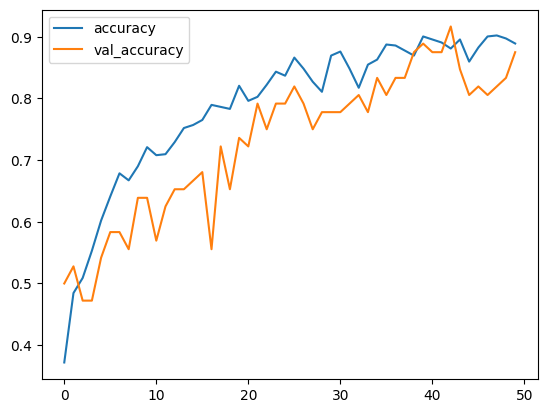

In [15]:
import matplotlib.pyplot as plt
# accuracy:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

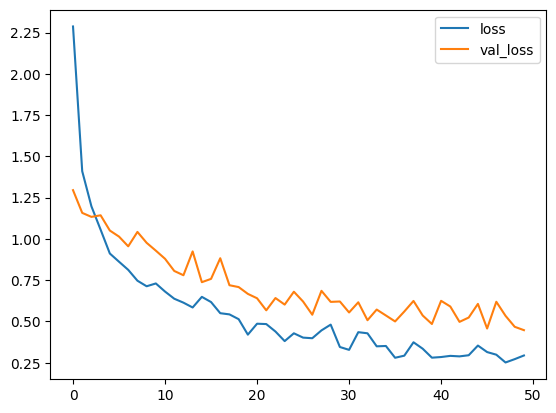

In [16]:
# loss:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

## Testing:

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# labels:
y_true = test_data_gen.classes
num_samples = len(test_data_gen)

#predictions:
y_pred = model.predict(test_data_gen, steps=num_samples, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# confusion matrix:
confusion = confusion_matrix(y_true, y_pred_labels)

#classification report:
print(classification_report(y_true, y_pred_labels))

10/10 [==============================] - 6s 646ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       120
           1       0.64      0.92      0.76        51
           2       1.00      0.98      0.99        54
           3       0.96      0.59      0.73        90

    accuracy                           0.82       315
   macro avg       0.85      0.84      0.83       315
weighted avg       0.85      0.82      0.82       315



## Saving the model to drive:

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')
model.save('/content/drive/MyDrive/Trained Model/medical.h5')